## Necessary imports

In [1]:
# Modules de base
import pandas as pd
import datetime
import haversine as hs
import matplotlib.cm as cm
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
%matplotlib inline
import folium
from folium import plugins

# Module relatif à Gurobi
from gurobipy import *

import warnings
warnings.filterwarnings("ignore")

## Useful functions

In [2]:
#Open Excel files
def open_excel_employes(file):
    #open and reads the excel with the employes list
    df_employe=pd.read_excel(file,sheet_name="Employees")
    return df_employe

def open_excel_tasks(file):
    #open and reads the excel with the task list
    df_tasks=pd.read_excel(file,sheet_name="Tasks")
    return df_tasks

def main(path):
    #returns both dataframes
    employes=open_excel_employes(path)
    tasks=open_excel_tasks(path)
    return employes, tasks

In [3]:
#Vecteurs d'horaire de début de journée
#We compute all times in minutes after midnight, since the tasks changes everyday
def convert_time_to_minute(dt):
    return dt.hour*60+dt.minute

def horaires_debut_journee(df_employe):
    return dict(zip(df_employe.EmployeeName, pd.to_datetime(df_employe.WorkingStartTime).apply(convert_time_to_minute)))

#Vecteurs d'horaire de fin de journée
def horaires_fin_journee(df_employe):
    return dict(zip(df_employe.EmployeeName, pd.to_datetime(df_employe.WorkingEndTime).apply(convert_time_to_minute)))

#Vecteurs durée de tâche
def duree_tache(df_tasks):
    return dict(zip(df_tasks.TaskId, df_tasks.TaskDuration))

#Vecteur des niveaux requis sur une task
def niveau_tache(df_tasks):
    return dict(zip(df_tasks.TaskId, df_tasks.Level))

#Vecteur des niveaux des agents
def niveau_agent(df_employe):
    return dict(zip(df_employe.EmployeeName, df_employe.Level))

#Vecteurs horaire ouverture de tâche
def ouverture_tache(df_tasks):
    return dict(zip(df_tasks.TaskId, pd.to_datetime(df_tasks.OpeningTime).apply(convert_time_to_minute)))

#Vecteurs horaire fermeture de tâche
def fermeture_tache(df_tasks):
    return dict(zip(df_tasks.TaskId, pd.to_datetime(df_tasks.ClosingTime).apply(convert_time_to_minute)))


In [4]:
def list_tasks(employes, tasks):
    #This function gives the list of tasks and adds a departure and arrival for all agents
    df3=employes[["EmployeeName",'Latitude', 'Longitude']] 
    df3=df3[0:1]
    
    df3=pd.concat([df3]*2, ignore_index=True)
    df3["EmployeeName"][0] += '_0'
    df3["EmployeeName"][1] += '_1'
    df3.set_index("EmployeeName", inplace=True)

    df4=tasks[["TaskId",'Latitude', 'Longitude']]
    df4.set_index("TaskId", inplace=True)
    list_coords = pd.concat([df3, df4])
    return list_coords


def nodes_dic(employes, tasks):
    #this function does the same thing as above, but keeps a dictionnary instead of a dataframe
    df3=employes[["EmployeeName",'Latitude', 'Longitude']] 
    df3=df3[0:1]
    
    df3=pd.concat([df3]*2, ignore_index=True)
    df3["EmployeeName"][0] += '_0'
    df3["EmployeeName"][1] += '_1'
    df3.set_index("EmployeeName", inplace=True)

    df4=tasks[["TaskId",'Latitude', 'Longitude']]
    df4.set_index("TaskId", inplace=True)
    list_coords = pd.concat([df3, df4])
    return list_coords.to_dict()["Latitude"]
    
    

def compute_distance(employes, tasks):
    #this function computes the euclidian distance between each node, and divides by 50km/h to keep a distance in time
    C= dict()
    list_coord = list_tasks(employes, tasks)
    
    lat=dict(list_coord.Latitude)
    long=dict(list_coord.Longitude)
    
    for key1 in lat:
        for key2 in lat:
            lat1, long1 = lat[key1], long[key1]
            lat2, long2 = lat[key2], long[key2]
            C[key1, key2] = hs.haversine([lat1, long1], [lat2, long2])*6/5
    #It returns a dictionnary        
    return C

The following cells are to be executed each time you want to test the model on new Instances. 

## Getting the data

In [6]:
#Ask user to chose for instance

print("Hello !!!\n")
print("The different data sets for this first version are :\n")
print("1 - Guinea\n")
print("2 - Italy\n")
print("3 - Poland\n")
print("4 - Bordeaux\n")
print("5 - Finland\n")



set_chosen = int(input("Enter a number between 1 and 5\n"))
if set_chosen<1 or set_chosen>5:
    print("error no set available")
    

sets = { 1: "GuineaGolf", 2: "Italy", 3: "Poland", 4: "Bordeaux", 5 : "Finland"}

choice= "../data/InstancesV1/Instance" +sets[set_chosen]+"V1.xlsx"
employes, tasks = main(choice)

employes.columns = ['EmployeeName', 'Latitude', 'Longitude', 'Skill', 'Level', 'WorkingStartTime', 'WorkingEndTime']

display(employes.head(5))
display(tasks)


Hello !!!

The different data sets for this first version are :

1 - Guinea

2 - Italy

3 - Poland

4 - Bordeaux

5 - Finland



,EmployeeName,Latitude,Longitude,Skill,Level,WorkingStartTime,WorkingEndTime
0,Mattia,45.226093,9.402008,Painting,1,8:00am,6:00pm
1,Paolo,45.226093,9.402008,Painting,2,8:00am,6:00pm
2,Carolina,45.226093,9.402008,Painting,2,8:00am,6:00pm


,TaskId,Latitude,Longitude,TaskDuration,Skill,Level,OpeningTime,ClosingTime
0,T1,45.275598,8.742639,30,Painting,2,8:00am,12:00pm
1,T2,45.291620,9.293758,40,Painting,1,8:00am,6:00pm
2,T3,45.354836,9.200242,30,Painting,1,8:00am,6:00pm
3,T4,45.186421,9.484720,40,Painting,1,2:00pm,6:00pm
4,T5,45.213584,9.088070,30,Painting,1,8:00am,6:00pm
5,T6,45.255491,9.596659,40,Painting,2,8:00am,6:00pm
6,T7,45.294706,9.834174,30,Painting,2,8:00am,6:00pm
7,T8,45.355288,9.001617,30,Painting,2,8:00am,6:00pm
8,T9,45.356011,9.555898,40,Painting,1,8:00am,12:00pm
9,T10,45.482644,9.405359,40,Painting,1,8:00am,6:00pm


## Building our data structures

In [7]:
D=horaires_debut_journee(employes)
F=horaires_fin_journee(employes)
S=duree_tache(tasks)
M=niveau_tache(tasks)
Q=niveau_agent(employes)
A=ouverture_tache(tasks)
B=fermeture_tache(tasks)

print("D =", D)
print("F =", F)
print("S =", S)
print("M =", M)
print("Q =", Q)
print("A =", A)
print("B =", B)

D = {'Mattia': 480, 'Paolo': 480, 'Carolina': 480}
F = {'Mattia': 1080, 'Paolo': 1080, 'Carolina': 1080}
S = {'T1': 30, 'T2': 40, 'T3': 30, 'T4': 40, 'T5': 30, 'T6': 40, 'T7': 30, 'T8': 30, 'T9': 40, 'T10': 40, 'T11': 30, 'T12': 30, 'T13': 40, 'T14': 40, 'T15': 40, 'T16': 45, 'T17': 45, 'T18': 45, 'T19': 40, 'T20': 40, 'T21': 40}
M = {'T1': 2, 'T2': 1, 'T3': 1, 'T4': 1, 'T5': 1, 'T6': 2, 'T7': 2, 'T8': 2, 'T9': 1, 'T10': 1, 'T11': 1, 'T12': 1, 'T13': 2, 'T14': 2, 'T15': 1, 'T16': 1, 'T17': 1, 'T18': 2, 'T19': 2, 'T20': 2, 'T21': 1}
Q = {'Mattia': 1, 'Paolo': 2, 'Carolina': 2}
A = {'T1': 480, 'T2': 480, 'T3': 480, 'T4': 840, 'T5': 480, 'T6': 480, 'T7': 480, 'T8': 480, 'T9': 480, 'T10': 480, 'T11': 480, 'T12': 480, 'T13': 480, 'T14': 960, 'T15': 480, 'T16': 480, 'T17': 480, 'T18': 480, 'T19': 480, 'T20': 480, 'T21': 480}
B = {'T1': 720, 'T2': 1080, 'T3': 1080, 'T4': 1080, 'T5': 1080, 'T6': 1080, 'T7': 1080, 'T8': 1080, 'T9': 720, 'T10': 1080, 'T11': 1080, 'T12': 1080, 'T13': 1080, 'T14':

In [8]:
all_nodes=nodes_dic(employes, tasks)
C=compute_distance(employes, tasks)

#We use these two lists to index our quicksums
#please refer to the written report for more detail

#all_nodes_0: is every node except the N+1 one
#all_nodes_1: is every node except the 0 : departure one

all_nodes_list=[]
for key in all_nodes:
    all_nodes_list.append(key)
    
all_nodes_0 = [all_nodes_list[0]] + all_nodes_list[2:len(all_nodes_list)+1]
all_nodes_1 = all_nodes_list[1:len(all_nodes_list)+1]  

## Optimizing with Gurobi

In [9]:
# -- Initialisation du modèle --
# m : Model
m = Model("PL-Model1")
m.params.TimeLimit = 3600

Set parameter Username


GurobiError: Version number is 10.0, license is for version 9.0

In [9]:
# -- Ajout des variables binaires et entière  --
# Xijk : Variables binaires du chemin i a j pour l'agent k
X = {(tache1, tache2, agent) : m.addVar(vtype = GRB.BINARY, name = f'X{tache1}_{tache2}_{agent}') for tache1 in all_nodes for tache2 in all_nodes for agent in Q if tache1!=tache2}

# Wi: Heure d'arrivée à la tâche i
#We have chosen to compute arrival times in minutes, compared to midnight
W = {tache : m.addVar(vtype = GRB.INTEGER, name = f'W{tache}') for tache in M}



In [10]:
# -- Ajout des contraintes


#Contrainte de dépot
constr_depot = dict()
constr_depot2 =dict()
for agent in Q:
    constr_depot[agent] = m.addConstr(quicksum([X[(all_nodes_0[0], tache ,agent)] for tache in all_nodes_1 ])== quicksum([X[(tache,all_nodes_1[0],agent)]  for tache in all_nodes_0]), name = f'depot{agent}')
    constr_depot2[agent] = m.addConstr(quicksum([X[(all_nodes_0[0], tache ,agent)] for tache in all_nodes_1 ])<=1 , name = f'depot2{agent}')
    
#Contrainte de débit
constr_debit = dict()
for agent in Q:
    for tache1 in M:
        constr_debit[tache1,agent]=m.addConstr(quicksum([X[(tache1, tache2 ,agent)] for tache2 in all_nodes_1 if tache1!=tache2 ]) == quicksum([X[(tache2, tache1 ,agent)] for tache2 in all_nodes_0 if tache1!=tache2 ]), name = f'debit_{tache1}_{agent}')


#Contrainte heures de travail
constr_heures_travail1 = dict()
constr_heures_travail2 = dict()

alpha=24*60
for agent in Q:
    for tache1 in M:
        constr_heures_travail1[tache1,agent]=m.addConstr(D[agent]+C[all_nodes_0[0],tache1]-W[tache1] <= alpha*(1-quicksum([X[(tache1, tache2 ,agent)] for tache2 in all_nodes_0 if tache1!=tache2])), name = f'heure1{tache1}_{agent}')
        constr_heures_travail2[tache1,agent]=m.addConstr(S[tache1]+C[tache1,all_nodes_1[0]]+W[tache1]- F[agent] <= alpha*(1-quicksum([X[(tache1, tache2 ,agent)] for tache2 in all_nodes if tache1!=tache2 ])), name = f'heure2{tache1}_{agent}')
        

#Contrainte compétences:
constr_compet= dict()
for tache1 in M:
    constr_compet[tache1]=m.addConstr(quicksum([X[(tache2, tache1 ,agent)]*M[tache1] for tache2 in all_nodes_0 for agent in Q if tache1!=tache2]) <= quicksum([X[(tache2, tache1 ,agent)]*Q[agent] for tache2 in all_nodes_0 for agent in Q if tache1!=tache2]), name = f'compet{tache1}')   

    
#Durée d'une tâche
constr_duree= dict()
for tache1 in M:
    for tache2 in M:
        if tache1!=tache2:
            constr_duree[tache1, tache2,agent]= m.addConstr(W[tache1]+S[tache1]+C[tache1,tache2]-W[tache2]<= (1-quicksum([X[(tache1, tache2 ,agent)] for agent in Q]))*alpha, name = f'duree{tache1}_{tache2}') 

#ouverture tâche
constr_ouvert1 = dict()
constr_ouvert2 = dict()
for tache1 in M:
    constr_ouvert1[tache1] = m.addConstr(A[tache1]<=W[tache1] , name = f'ouve1{tache1}')
    constr_ouvert2[tache1] = m.addConstr(W[tache1]<= B[tache1]-S[tache1] , name = f'ouve2{tache1}')
    
#attribution des tâches
constr_attribution = dict()
for tache1 in M:
    constr_attribution[tache1] = m.addConstr( quicksum([X[(tache1, tache2 ,agent)] for tache2 in all_nodes_1 for agent in Q if tache1!=tache2])==1,  f'attribution{tache1}' ) 

In [11]:
# -- Ajout de la fonction objectif --
m.setObjective(quicksum([X[(tache1, tache2 ,agent)]*C[tache1,tache2] for tache1 in all_nodes_0 for tache2 in all_nodes_1 for agent in Q if tache1!=tache2]), GRB.MINIMIZE)

# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 1

# -- Mise à jour du modèle  --
m.update()

# -- Affichage en mode texte du PL --
#print(m.display())

In [12]:
# -- Résolution --
m.optimize()

print(m, "\n")




# -- Affichage de la solution --
print("L'affectation optimale des trajets se fait comme suit:")
for task in M:
    print("Heure d'arrivée à la tâche ", task, " :",W[task].x, " min")

for agent in Q:    
    for task1 in all_nodes:
        for task2 in all_nodes:
            if task1!=task2:
                if X[(task1, task2 ,agent)].x !=0:
                    print("trajet de ", task1, "à ", task2, "par l'agent ", agent," :", X[(task1, task2 ,agent)].x)
                    
                    
print("Final MIP gap value: %f" % m.MIPGap)                     
                    
                    

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 194 rows, 274 columns and 1602 nonzeros
Model fingerprint: 0xe4955bcf
Variable types: 0 continuous, 274 integer (264 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [7e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 46 rows and 112 columns
Presolve time: 0.01s
Presolved: 148 rows, 162 columns, 928 nonzeros
Variable types: 0 continuous, 162 integer (152 binary)

Root relaxation: objective 2.199482e+02, 50 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  219.94822    0   20          -  219.94822      -     -    0s
     0     0  233.80542    0   27          -  233.80542      -     -    0s
   

## Results and analysis

In [13]:
# -- Affichage de la solution --
dic={}
name="./Solutions/Text/Solution"+sets[set_chosen]+"V1"+"By1.txt"
f = open(name, "w")
f.write("taskId;performed;employeeName;startTime;\n")
for agent in Q:
    dic[agent]={}
for task1 in M:
    best_solution=0
    best_txt=""
    for agent in Q: 
        for task2 in all_nodes: 
        #we consider that a task is done by the agent if he goes from this task to another or to his house
            if task1!=task2:
                if (X[(task1, task2 ,agent)].x !=0):
                    best_solution=int(X[(task1, task2 ,agent)].x)
                    best_txt= task1+";"+ str(int(X[(task1, task2 ,agent)].x))+";"+str(agent)  +";"+str(int(W[task1].x))+"\n"
                    dic[agent][task1]=int(W[task1].x)
                    break
    if best_solution==1:
        f.write(best_txt)
    else: 
        f.write(task1+";0;;;\n")
f.close()


print(dic)
                         

{'Valentin': {'T3': 576, 'T4': 837, 'T5': 501, 'T6': 767, 'T7': 923, 'T9': 998}, 'Ambre': {'T1': 636, 'T2': 514, 'T8': 775, 'T10': 843}}


In [14]:
#Compute for the set chosen the number of constraints (see report)
def constraints(tasks, employees):
    return employees+3*tasks+2*employees*tasks+ tasks**2
print("Le nombre de contraintes pour "+ sets[set_chosen]+" est :" , constraints(len(M), len(Q)))

Le nombre de contraintes pour Bordeaux est : 172


In [15]:
#To produce the path of the employees on a map
center = [employes.loc[0,'Latitude'], employes.loc[0,'Longitude']] #centre de la carte
e=employes.set_index('EmployeeName')
t=tasks.set_index('TaskId')

m = folium.Map(location=center)

for ind, lat, lon, com in tasks[['Latitude', 'Longitude', 'TaskId']][:50].itertuples():
    folium.Marker(location=[lat,lon], popup=com, icon=folium.Icon(color="blue", icon="glyphicon glyphicon-wrench") ).add_to(m) 

lgd_txt = '<span style="color: {col};">{txt}</span>'    #html pour l'affichage de la légende
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
count=-1
for agent in Q:
    count+=1
    color=colors[count]
    feature_group = folium.FeatureGroup(name= lgd_txt.format( txt= agent, col= color)) #legend
    dic_of_tasks=dic[agent]
    dic_t=sorted(dic_of_tasks, key=dic_of_tasks.get)
    coordinates_e = [e.loc[agent,'Latitude'], e.loc[agent,'Longitude']]
    folium.Marker(location=coordinates_e, popup='Dépôt', icon=folium.Icon(color='red', icon="home")).add_to(feature_group) #lieu du dépôt
    pl= folium.PolyLine([coordinates_e]+[[t.loc[dic_t[i],'Latitude'], t.loc[dic_t[i],'Longitude']] for i in range(len(dic_t))]+[coordinates_e], color=color)
    pl.add_to(feature_group)
    '''folium.plugins.AntPath([coordinates_e]+[[t.loc[dic_t[i],'Latitude'], t.loc[dic_t[i],'Longitude']] for i in range(len(dic_t))]+[coordinates_e], {
  "delay": 400,
  "dashArray": [
    10,
    20
  ],
  "weight": 5,
  "color": color,
  "pulseColor": color,
  "paused": False,
  "reverse": False,
        "delay":2000
} ).add_to(feature_group)'''
    feature_group.add_to(m)

folium.LayerControl().add_to(m) 
m.save('./Solutions/Map/map_'+sets[set_chosen]+'.html')

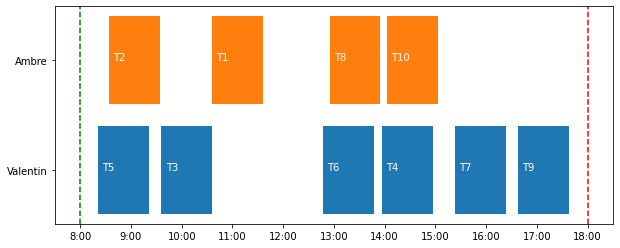

In [16]:
#To produce the visual timetable in png format
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
data = []
agents= [agent for agent in Q]
for agent in Q:
    dic_of_tasks=dic[agent]
    for task, time in dic_of_tasks.items():
        data.append((time, time+S[task], agent, task))
        
cats = {agents[i]:i for i in range(len(agents))}
colormapping = {agents[i]:"C"+str(i) for i in range(len(agents))}

verts = {agents[i]:[]for i in range(len(agents))}
colors = {agents[i]:[]for i in range(len(agents))}
for d in data:
    v =  [(d[0], cats[d[2]]-.4),
          (d[0], cats[d[2]]+.4),
          (d[1], cats[d[2]]+.4),
          (d[1], cats[d[2]]-.4),
          (d[0], cats[d[2]]-.4)]
    verts[d[2]].append(v)
    colors[d[2]].append(colormapping[d[2]])
    ax.annotate(d[3], (d[0]+5, cats[d[2]]), color='w')

for cat in verts.keys():
    bars = PolyCollection(verts[cat], facecolors=colors[cat])
    ax.add_collection(bars)
    
ax.set_yticks([i for i in range(len(agents))])
ax.set_yticklabels(agents)

ax.set_xticks([i for i in range(480,1140, 60)])
ax.set_xticklabels([str(datetime.timedelta(minutes=i))[:-3] for i in range(480,1140, 60)])

ax.axvline(x = 480, color = "green", linestyle='--', label = "Start of the day") 
ax.axvline(x = 1080, color = "red", linestyle='--', label = "End of the day") 
ax.autoscale()
plt.savefig('./Solutions/Timetable/timetable_'+sets[set_chosen]+'.png', transparent=True)